## Goodreads Book Recommender

#### Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

In [146]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 150, 750, 2500

# For titles in my_books that don't perfectly match df_books and can't be auto-matched
titles_to_replace = {
    "Children of Time (Children of Time #1)":"Children of Time",
    "King Leopold's Ghost: A Story of Greed, Terror, and Heroism in Colonial Africa":"King Leopold's Ghost",
    "Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism":"Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism: The Belief System That Enables Us to Eat Some Animals and Not Others",
    "Astrophysics for People in a Hurry (Astrophysics for People in a Hurry Series)":"Astrophysics for People in a Hurry",
    "Man-Eaters Of Kumaon":"The Temple Tiger and More Man-Eaters of Kumaon",    
}

### 0.1 - Load and Prepare Data

In [147]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [148]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [149]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,119 readers by 315,354 books


In [150]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")
my_books["Title"].replace(titles_to_replace, inplace=True)

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# First match on book_id
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="inner", on="book_id", suffixes=["_mb","_dfb"]
            ).rename(columns={"title_dfb":"title"}).drop("title_mb", axis=1)
print(f"Matching on book_id: {my_books_1.shape[0]}")

# Next match on title
my_books_2 = pd.merge(
    my_books[~my_books["book_id"].isin(my_books_1["book_id"])], # not matched on id
    df_books[["book_id", "title", "ratings_count", "avg_rating"]], 
    how="inner", on="title", suffixes=["_mb","_dfb"]
    ).sort_values(["title", "ratings_count"], ascending=False)\
     .drop_duplicates(subset=["title"])\
     .rename(columns={"book_id_dfb":"book_id"})
print(f"Matching on title: {my_books_2[~my_books_2['book_id'].isin(my_books_1['book_id'])].shape[0]}")

# Concat matching on book_id and matching on title
my_books_3 = pd.concat([my_books_1, my_books_2[["book_id", "rating", "title"]]])\
               .drop_duplicates(subset="title")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

# Reshape to sparse matrix dimensions
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 171
Matching on book_id: 83
Matching on title: 24
Total matches: 107, 62.57% of total


In [151]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [152]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [153]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=100, n_recs=20, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [154]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [155]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

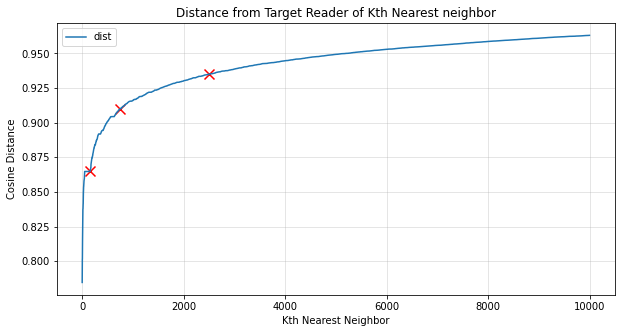

In [156]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews_norm, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:10000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="red", marker="x", s=100)
plt.scatter(MD, dists[0,MD], color="red", marker="x", s=100)
plt.scatter(LG, dists[0,LG], color="red", marker="x", s=100)
plt.show()

In [157]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Large neighborhood contains {lg_neighborhood_ratings['book_index'].nunique():,} books")

Small neighborhood contains 360 books
Medium neighborhood contains 4,367 books
Large neighborhood contains 15,109 books


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

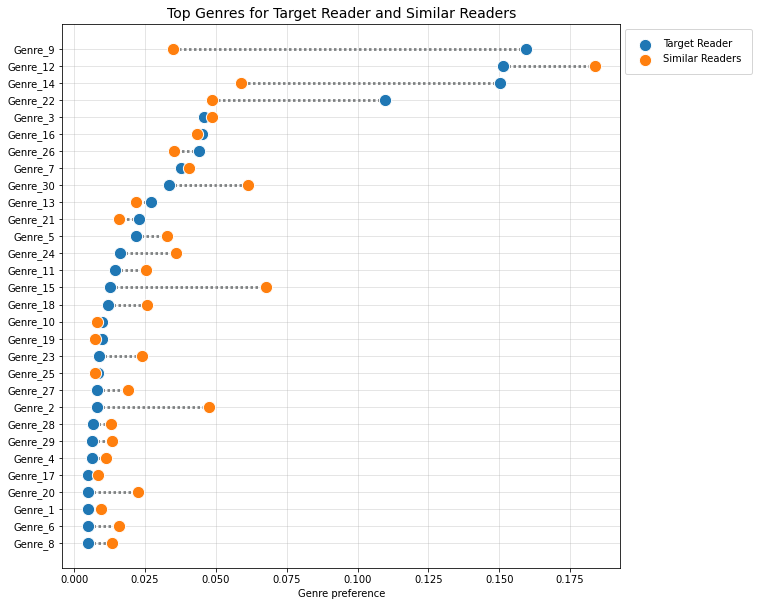

In [158]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [159]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
118,Ready Player One,4.31,376328.0,2011.0,14.0%,https://www.goodreads.com/book/show/9969571-re...
209,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,9.3%,https://www.goodreads.com/book/show/7235533-th...
173,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,9.3%,https://www.goodreads.com/book/show/2767052-th...
42,Dark Matter,4.10,75794.0,2016.0,9.3%,https://www.goodreads.com/book/show/27833670-d...
185,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,7.0%,https://www.goodreads.com/book/show/186074.The...
182,The Martian,4.39,435440.0,2014.0,7.0%,https://www.goodreads.com/book/show/18007564-t...
12,All the Light We Cannot See,4.31,498685.0,2014.0,7.0%,https://www.goodreads.com/book/show/18143977-a...
104,"Old Man's War (Old Man's War, #1)",4.23,100702.0,2007.0,7.0%,https://www.goodreads.com/book/show/51964.Old_...
89,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,2011.0,7.0%,https://www.goodreads.com/book/show/8855321-le...
103,"Off to Be the Wizard (Magic 2.0, #1)",3.98,13834.0,2014.0,7.0%,https://www.goodreads.com/book/show/18616975-o...


In [160]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
209,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
185,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,https://www.goodreads.com/book/show/186074.The...
175,The Josephine B Trilogy,4.45,132.0,2006.0,https://www.goodreads.com/book/show/1308176.Th...
163,"The Final Empire (Mistborn, #1)",4.43,216149.0,2006.0,https://www.goodreads.com/book/show/68428.The_...
7,A Night Without Stars,4.41,1758.0,2016.0,https://www.goodreads.com/book/show/28530221-a...
59,Gates of Fire: An Epic Novel of the Battle of ...,4.40,18299.0,2005.0,https://www.goodreads.com/book/show/1305.Gates...
182,The Martian,4.39,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
6,A Gentleman in Moscow,4.37,44419.0,2016.0,https://www.goodreads.com/book/show/29430012-a...
66,Homicide: A Year on the Killing Streets,4.37,10487.0,1991.0,https://www.goodreads.com/book/show/18956.Homi...
128,Salt to the Sea,4.36,44903.0,2016.0,https://www.goodreads.com/book/show/25614492-s...


In [161]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=15,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
9,The Josephine B Trilogy,4.45,132.0,https://www.goodreads.com/book/show/1308176.Th...
1,A Thousand Splendid Suns,4.34,835172.0,https://www.goodreads.com/book/show/128029.A_T...
7,The Emperor of All Maladies: A Biography of Ca...,4.29,49534.0,https://www.goodreads.com/book/show/7170627-th...
2,Bury My Heart at Wounded Knee: An Indian Histo...,4.21,41180.0,https://www.goodreads.com/book/show/76401.Bury...
11,The Red Tent,4.16,428809.0,https://www.goodreads.com/book/show/4989.The_R...
4,Patriotism,4.12,1869.0,https://www.goodreads.com/book/show/62795.Patr...
6,The Dream of a Ridiculous Man,4.07,4927.0,https://www.goodreads.com/book/show/329866.The...
10,The Picture of Dorian Gray,4.06,607145.0,https://www.goodreads.com/book/show/5297.The_P...
8,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...
12,The Tiger: A True Story of Vengeance and Survival,4.01,6156.0,https://www.goodreads.com/book/show/7624594-th...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
1,A Night Without Stars,4.41,1758.0,https://www.goodreads.com/book/show/28530221-a...
56,The Martian,4.39,435440.0,https://www.goodreads.com/book/show/18007564-t...
62,The Stand,4.34,449730.0,https://www.goodreads.com/book/show/149267.The...
26,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
64,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,17174.0,https://www.goodreads.com/book/show/32109569-w...
35,"Pandora's Star (Commonwealth Saga, #1)",4.24,1312.0,https://www.goodreads.com/book/show/6136470-pa...
31,"Old Man's War (Old Man's War, #1)",4.23,100702.0,https://www.goodreads.com/book/show/51964.Old_...
49,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...
27,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,https://www.goodreads.com/book/show/8855321-le...
5,Anathem,4.18,45672.0,https://www.goodreads.com/book/show/2845024-an...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
10,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,9145.0,https://www.goodreads.com/book/show/33917107-o...
11,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
6,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
9,Hun Sen’s Cambodia,4.20,105.0,https://www.goodreads.com/book/show/21945075-h...
21,"Titan: The Life of John D. Rockefeller, Sr.",4.19,8970.0,https://www.goodreads.com/book/show/16121.Titan
3,"Blood Meridian, or the Evening Redness in the ...",4.18,72755.0,https://www.goodreads.com/book/show/394535.Blo...
20,The Sleepwalkers: How Europe Went to War in 1914,4.18,3830.0,https://www.goodreads.com/book/show/18669169-t...
15,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...
17,"The Conservative Heart: How to Build a Fairer,...",4.13,564.0,https://www.goodreads.com/book/show/25723233-t...
7,Fuzzy Nation,4.10,17539.0,https://www.goodreads.com/book/show/9647532-fu...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
10,The Authoritarians,4.31,354.0,https://www.goodreads.com/book/show/1971601.Th...
8,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...
13,The Hero With a Thousand Faces,4.24,18378.0,https://www.goodreads.com/book/show/588138.The...
2,Dear Data,4.22,227.0,https://www.goodreads.com/book/show/28465052-d...
5,Meditations,4.20,45727.0,https://www.goodreads.com/book/show/30659.Medi...
0,A Brief History of Time,4.13,173373.0,https://www.goodreads.com/book/show/3869.A_Bri...
12,"The Fabric of the Cosmos: Space, Time, and the...",4.11,24820.0,https://www.goodreads.com/book/show/22435.The_...
16,The Left Hand of Darkness,4.05,63749.0,https://www.goodreads.com/book/show/18423.The_...
14,The Hidden Reality: Parallel Universes and the...,4.05,12465.0,https://www.goodreads.com/book/show/8167094-th...
1,A Field Guide to Getting Lost,4.03,5251.0,https://www.goodreads.com/book/show/76479.A_Fi...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
5,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0,https://www.goodreads.com/book/show/9963483-fa...
2,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0,https://www.goodreads.com/book/show/25894085-b...
4,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0,https://www.goodreads.com/book/show/5944774-de...
9,Imagining the Kingdom: How Worship Works,4.15,390.0,https://www.goodreads.com/book/show/15863575-i...
15,The Essential Dalai Lama: His Important Teachings,4.12,315.0,https://www.goodreads.com/book/show/237924.The...
16,The Obstacle Is the Way: The Timeless Art of T...,4.11,13544.0,https://www.goodreads.com/book/show/18668059-t...
7,How Will You Measure Your Life?,4.06,11938.0,https://www.goodreads.com/book/show/13425570-h...
8,If the Oceans Were Ink: An Unlikely Friendship...,4.02,792.0,https://www.goodreads.com/book/show/22320455-i...
14,The Course of Love,4.01,7488.0,https://www.goodreads.com/book/show/27845690-t...
1,A Year of Biblical Womanhood,3.94,6528.0,https://www.goodreads.com/book/show/13544022-a...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
3,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
6,Influence: The Psychology of Persuasion,4.18,47682.0,https://www.goodreads.com/book/show/28815.Infl...
14,"Thinking, Fast and Slow",4.09,144569.0,https://www.goodreads.com/book/show/11468377-t...
11,The Leadership Challenge,4.04,6679.0,https://www.goodreads.com/book/show/1758199.Th...
12,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
9,The Checklist Manifesto How to Get Things Right,4.03,268.0,https://www.goodreads.com/book/show/10245518-t...
10,The Checklist Manifesto: How to Get Things Right,4.03,24634.0,https://www.goodreads.com/book/show/6667514-th...
4,Curious: The Desire to Know and Why Your Futur...,3.97,691.0,https://www.goodreads.com/book/show/22047408-c...
2,Bringing Up Bébé: One American Mother Discover...,3.95,18924.0,https://www.goodreads.com/book/show/13152287-b...
8,"Smartcuts: How Hackers, Innovators, and Icons ...",3.94,3079.0,https://www.goodreads.com/book/show/20910174-s...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
3,Gates of Fire: An Epic Novel of the Battle of ...,4.40,18299.0,https://www.goodreads.com/book/show/1305.Gates...
9,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,123373.0,https://www.goodreads.com/book/show/127455.The...
5,"Outlander (Outlander, #1)",4.21,531055.0,https://www.goodreads.com/book/show/10964.Outl...
1,Elantris,4.17,1420.0,https://www.goodreads.com/book/show/10803709-e...
2,"Elantris (Elantris, #1)",4.17,100115.0,https://www.goodreads.com/book/show/68427.Elan...
0,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,133239.0,https://www.goodreads.com/book/show/45107.Assa...
6,"Red Queen (Red Queen, #1)",4.08,205243.0,https://www.goodreads.com/book/show/22328546-r...
8,The Goblin Emperor,4.05,12081.0,https://www.goodreads.com/book/show/17910048-t...
4,"Kushiel's Dart (Phèdre's Trilogy, #1)",4.04,52997.0,https://www.goodreads.com/book/show/153008.Kus...
11,The Queen of the Tearling (The Queen of the Te...,4.02,43751.0,https://www.goodreads.com/book/show/18712886-t...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
7,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
2,Masters of Doom: How Two Guys Created an Empir...,4.23,7357.0,https://www.goodreads.com/book/show/222146.Mas...
4,No One Writes Back,4.19,154.0,https://www.goodreads.com/book/show/17591572-n...
6,"Searching for Sunday: Loving, Leaving, and Fin...",4.09,5560.0,https://www.goodreads.com/book/show/22574709-s...
11,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0,https://www.goodreads.com/book/show/392563.The...
0,Grace's Guide: The Art of Pretending to Be a G...,4.04,6917.0,https://www.goodreads.com/book/show/22168240-g...
5,On the Move: A Life,4.03,9163.0,https://www.goodreads.com/book/show/24972194-o...
9,"The Eyre Affair (Thursday Next, #1)",3.91,86867.0,https://www.goodreads.com/book/show/27003.The_...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
2,A Gentleman in Moscow,4.37,44419.0,https://www.goodreads.com/book/show/29430012-a...
8,Jackalope Wives,4.35,460.0,https://www.goodreads.com/book/show/20527580-j...
3,All the Light We Cannot See,4.31,498685.0,https://www.goodreads.com/book/show/18143977-a...
13,The Amazing Adventures of Kavalier & Clay,4.17,149976.0,https://www.goodreads.com/book/show/3985.The_A...
6,Dark Matter,4.10,75794.0,https://www.goodreads.com/book/show/27833670-d...
15,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,https://www.goodreads.com/book/show/15819028-t...
20,Thousandth Night,4.10,434.0,https://www.goodreads.com/book/show/18129561-t...
11,One Hundred Years of Solitude,4.04,497852.0,https://www.goodreads.com/book/show/320.One_Hu...
17,The Night Circus,4.03,441272.0,https://www.goodreads.com/book/show/9361589-th...
12,Station Eleven,4.02,166920.0,https://www.goodreads.com/book/show/20170404-s...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,ratings_count,url
1,Beyond the Aquila Rift: The Best of Alastair R...,4.30,163.0,https://www.goodreads.com/book/show/28931839-b...
5,The Circular Ruins,4.30,409.0,https://www.goodreads.com/book/show/28110198-t...
0,2016 on Goodreads,4.25,1167.0,https://www.goodreads.com/book/show/33232571-2...
4,Other People,4.19,373.0,https://www.goodreads.com/book/show/16176131-o...
2,Diary of an AssCan: A Mark Watney Short Story ...,4.09,1536.0,https://www.goodreads.com/book/show/26852117-d...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [162]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhood_ratings

In [163]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 15,216 books


In [164]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=15)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [165]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [166]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [167]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
5,The Martian,4.39,3.514596,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
17,The Name of the Wind (The Kingkiller Chronicle...,4.55,2.158859,416634.0,2007.0,https://www.goodreads.com/book/show/186074.The...
18,Ready Player One,4.31,2.050604,376328.0,2011.0,https://www.goodreads.com/book/show/9969571-re...
24,Brave New World,3.97,1.453130,1043619.0,1998.0,https://www.goodreads.com/book/show/5129.Brave...
25,"The Hunger Games (The Hunger Games, #1)",4.34,1.449506,4899965.0,2008.0,https://www.goodreads.com/book/show/2767052-th...
26,Seveneves,3.98,1.432847,47286.0,2015.0,https://www.goodreads.com/book/show/22816087-s...
28,"The Final Empire (Mistborn, #1)",4.43,1.286818,216149.0,2006.0,https://www.goodreads.com/book/show/68428.The_...
29,"The Way of Kings (The Stormlight Archive, #1)",4.64,1.276123,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
30,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,1.249011,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
32,"Ancillary Justice (Imperial Radch, #1)",3.97,1.187229,40736.0,2013.0,https://www.goodreads.com/book/show/17333324-a...


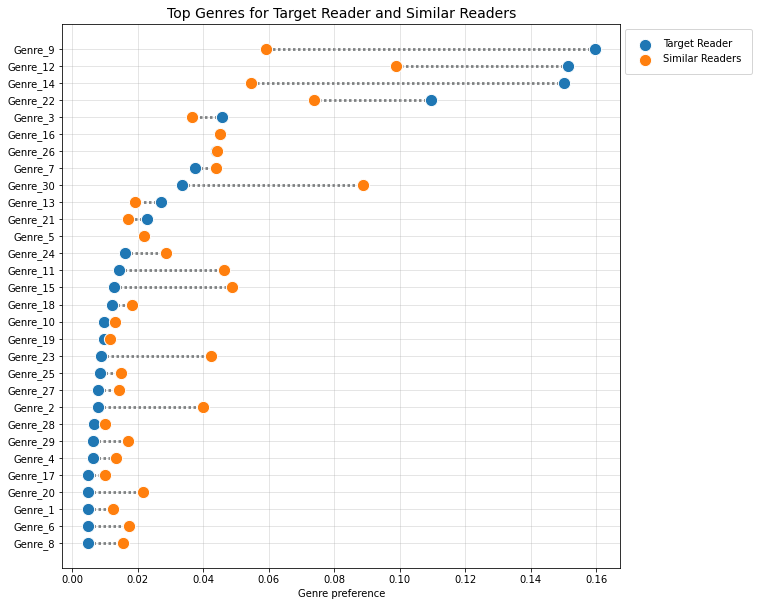

In [168]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [169]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, n=50, write_to_excel=True)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
5551,The Martian,4.39,435440.0,2014.0,9.3%,https://www.goodreads.com/book/show/18007564-t...
3650,Ready Player One,4.31,376328.0,2011.0,7.9%,https://www.goodreads.com/book/show/9969571-re...
5640,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,5.5%,https://www.goodreads.com/book/show/186074.The...
5032,The Fault in Our Stars,4.26,2429317.0,2012.0,5.3%,https://www.goodreads.com/book/show/11870085-t...
5309,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,5.0%,https://www.goodreads.com/book/show/2767052-th...
849,Brave New World,3.97,1043619.0,1998.0,3.7%,https://www.goodreads.com/book/show/5129.Brave...
447,"Ancillary Justice (Imperial Radch, #1)",3.97,40736.0,2013.0,3.5%,https://www.goodreads.com/book/show/17333324-a...
5239,The Handmaid's Tale,4.07,648783.0,1998.0,3.4%,https://www.goodreads.com/book/show/38447.The_...
4596,The Book Thief,4.36,1193697.0,2005.0,3.3%,https://www.goodreads.com/book/show/19063.The_...
2712,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,2011.0,3.3%,https://www.goodreads.com/book/show/8855321-le...


In [170]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, n=50, write_to_excel=True)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
3437,Patrick O'Brian's Aubrey/Maturin Series,4.83,420.0,2010.0,https://www.goodreads.com/book/show/8432716-pa...
6374,"The Way of Kings, Part 2 (The Stormlight Archi...",4.78,7803.0,2011.0,https://www.goodreads.com/book/show/11221285-t...
1466,ESV Study Bible,4.76,9036.0,2008.0,https://www.goodreads.com/book/show/5031805-es...
2890,Mark of the Lion Trilogy,4.76,9189.0,1998.0,https://www.goodreads.com/book/show/95602.Mark...
1343,Digger: The Complete Omnibus,4.72,392.0,2013.0,https://www.goodreads.com/book/show/19276094-d...
3809,Saga: Book One,4.70,4201.0,2014.0,https://www.goodreads.com/book/show/22078240-saga
1811,Free Verse,4.69,114.0,1991.0,https://www.goodreads.com/book/show/365331.Fre...
3810,Saga: Book Two,4.68,866.0,2017.0,https://www.goodreads.com/book/show/32926680-saga
3967,Sherlock Holmes: The Definitive Collection,4.68,240.0,2017.0,https://www.goodreads.com/book/show/34429916-s...
6373,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011.0,https://www.goodreads.com/book/show/9329354-th...


In [171]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4, 
    n_recs=20,
    write_to_excel=True
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
59,The Picture of Dorian Gray,4.06,607145.0,https://www.goodreads.com/book/show/5297.The_P...
88,On Writing: A Memoir of the Craft,4.31,135528.0,https://www.goodreads.com/book/show/10569.On_W...
116,The Godfather,4.36,259150.0,https://www.goodreads.com/book/show/22034.The_...
117,A Thousand Splendid Suns,4.34,835172.0,https://www.goodreads.com/book/show/128029.A_T...
139,The Underground Railroad,4.03,86839.0,https://www.goodreads.com/book/show/30555488-t...
147,World War Z: An Oral History of the Zombie War,4.01,320129.0,https://www.goodreads.com/book/show/8908.World...
236,The Things They Carried,4.12,175771.0,https://www.goodreads.com/book/show/133518.The...
241,The Wright Brothers,4.15,38372.0,https://www.goodreads.com/book/show/22609391-t...
262,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...
320,India After Gandhi: The History of the World's...,4.35,9652.0,https://www.goodreads.com/book/show/356824.Ind...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
5,The Martian,4.39,435440.0,https://www.goodreads.com/book/show/18007564-t...
33,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,https://www.goodreads.com/book/show/8855321-le...
36,Do Androids Dream of Electric Sheep?,4.08,229370.0,https://www.goodreads.com/book/show/7082.Do_An...
43,"Binti (Binti, #1)",4.02,7945.0,https://www.goodreads.com/book/show/25667918-b...
79,"Old Man's War (Old Man's War, #1)",4.23,100702.0,https://www.goodreads.com/book/show/51964.Old_...
96,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,15139.0,https://www.goodreads.com/book/show/22733729-t...
103,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,17174.0,https://www.goodreads.com/book/show/32109569-w...
109,The Collapsing Empire (The Interdependency #1),4.11,7652.0,https://www.goodreads.com/book/show/30078567-t...
126,Childhood's End,4.09,89107.0,https://www.goodreads.com/book/show/414999.Chi...
191,"The Passage (The Passage, #1)",4.04,129151.0,https://www.goodreads.com/book/show/6690798-th...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
81,Elon Musk: Inventing the Future,4.24,63849.0,https://www.goodreads.com/book/show/22543496-e...
200,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
245,"Blood Meridian, or the Evening Redness in the ...",4.18,72755.0,https://www.goodreads.com/book/show/394535.Blo...
250,The Everything Store: Jeff Bezos and the Age o...,4.07,22546.0,https://www.goodreads.com/book/show/17660462-t...
269,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
274,"No Place to Hide: Edward Snowden, the NSA, and...",4.08,8572.0,https://www.goodreads.com/book/show/18213403-n...
287,Fuzzy Nation,4.10,17539.0,https://www.goodreads.com/book/show/9647532-fu...
304,"Red Notice: A True Story of High Finance, Murd...",4.35,10976.0,https://www.goodreads.com/book/show/22609522-r...
385,Daemon (Daemon #1),4.17,9355.0,https://www.goodreads.com/book/show/6665847-da...
398,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
84,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...
85,The Left Hand of Darkness,4.05,63749.0,https://www.goodreads.com/book/show/18423.The_...
100,Pride and Prejudice,4.25,2078406.0,https://www.goodreads.com/book/show/1885.Pride...
113,A Brief History of Time,4.13,173373.0,https://www.goodreads.com/book/show/3869.A_Bri...
224,The Brothers Karamazov,4.31,158410.0,https://www.goodreads.com/book/show/4934.The_B...
265,The Grand Design,4.01,44203.0,https://www.goodreads.com/book/show/8520362-th...
268,Our Mathematical Universe: My Quest for the Ul...,4.12,1937.0,https://www.goodreads.com/book/show/19395553-o...
271,The Unbearable Lightness of Being,4.08,209734.0,https://www.goodreads.com/book/show/9717.The_U...
336,The Hidden Reality: Parallel Universes and the...,4.05,12465.0,https://www.goodreads.com/book/show/8167094-th...
344,The Gene: An Intimate History,4.36,9874.0,https://www.goodreads.com/book/show/27276428-t...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
61,Man's Search for Meaning,4.33,179906.0,https://www.goodreads.com/book/show/4069.Man_s...
207,The Subtle Art of Not Giving a F*ck: A Counter...,4.02,60032.0,https://www.goodreads.com/book/show/28257707-t...
253,Quiet: The Power of Introverts in a World That...,4.04,208008.0,https://www.goodreads.com/book/show/8520610-quiet
281,The Last Lecture,4.25,245804.0,https://www.goodreads.com/book/show/2318271.Th...
310,Einstein: His Life and Universe,4.08,73712.0,https://www.goodreads.com/book/show/10884.Eins...
358,The Prophet,4.23,145579.0,https://www.goodreads.com/book/show/2547.The_P...
370,The Better Angels of Our Nature: Why Violence ...,4.20,11991.0,https://www.goodreads.com/book/show/11107244-t...
504,How Will You Measure Your Life?,4.06,11938.0,https://www.goodreads.com/book/show/13425570-h...
559,The 7 Habits of Highly Effective People: Power...,4.05,330726.0,https://www.goodreads.com/book/show/36072.The_...
601,The Defining Decade: Why Your Twenties Matter-...,4.12,13364.0,https://www.goodreads.com/book/show/13523061-t...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
56,"Thinking, Fast and Slow",4.09,144569.0,https://www.goodreads.com/book/show/11468377-t...
60,The Power of Habit: Why We Do What We Do in Li...,4.03,160604.0,https://www.goodreads.com/book/show/12609433-t...
87,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
120,How to Win Friends and Influence People,4.14,296690.0,https://www.goodreads.com/book/show/4865.How_t...
167,The Selfish Gene,4.12,98053.0,https://www.goodreads.com/book/show/61535.The_...
186,An Astronaut's Guide to Life on Earth,4.14,26389.0,https://www.goodreads.com/book/show/18170143-a...
199,Predictably Irrational: The Hidden Forces That...,4.10,63635.0,https://www.goodreads.com/book/show/1713426.Pr...
210,The End of Eternity,4.21,27229.0,https://www.goodreads.com/book/show/509784.The...
220,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
257,Influence: The Psychology of Persuasion,4.18,47682.0,https://www.goodreads.com/book/show/28815.Infl...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
53,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,123373.0,https://www.goodreads.com/book/show/127455.The...
67,Dune (Dune Chronicles #1),4.20,494553.0,https://www.goodreads.com/book/show/234225.Dune
105,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,133239.0,https://www.goodreads.com/book/show/45107.Assa...
127,"Promise of Blood (Powder Mage, #1)",4.16,22179.0,https://www.goodreads.com/book/show/15790883-p...
141,"Elantris (Elantris, #1)",4.17,100115.0,https://www.goodreads.com/book/show/68427.Elan...
162,The Emperor's Blades (Chronicle of the Unhewn ...,4.15,20726.0,https://www.goodreads.com/book/show/17910124-t...
170,The Traitor Baru Cormorant (Baru Cormorant #1),4.04,5025.0,https://www.goodreads.com/book/show/23444482-t...
185,"The Black Prism (Lightbringer, #1)",4.24,60913.0,https://www.goodreads.com/book/show/7165300-th...
206,"Prince of Fools (The Red Queen's War, #1)",4.07,12280.0,https://www.goodreads.com/book/show/18693743-p...
230,The Lions of Al-Rassan,4.27,14200.0,https://www.goodreads.com/book/show/104101.The...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
98,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
182,Breakfast of Champions,4.08,180318.0,https://www.goodreads.com/book/show/4980.Break...
189,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
190,You're Never Weird on the Internet,4.14,29419.0,https://www.goodreads.com/book/show/23705512-y...
356,"The Big Sleep (Philip Marlowe, #1)",4.03,85883.0,https://www.goodreads.com/book/show/2052.The_B...
432,Infinite Jest,4.31,47926.0,https://www.goodreads.com/book/show/6759.Infin...
441,Just Kids,4.14,111092.0,https://www.goodreads.com/book/show/341879.Jus...
442,The Nix,4.11,25087.0,https://www.goodreads.com/book/show/28251002-t...
568,Total Recall: My Unbelievably True Life Story,4.11,7295.0,https://www.goodreads.com/book/show/14546626-t...
733,The Etymologicon: A Circular Stroll through th...,4.21,4106.0,https://www.goodreads.com/book/show/12870068-t...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
37,Dark Matter,4.10,75794.0,https://www.goodreads.com/book/show/27833670-d...
38,One Hundred Years of Solitude,4.04,497852.0,https://www.goodreads.com/book/show/320.One_Hu...
57,Neverwhere,4.18,275822.0,https://www.goodreads.com/book/show/14497.Neve...
121,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
129,The Shadow of the Wind (The Cemetery of Forgot...,4.25,269927.0,https://www.goodreads.com/book/show/1232.The_S...
132,All the Light We Cannot See,4.31,498685.0,https://www.goodreads.com/book/show/18143977-a...
169,The Amazing Adventures of Kavalier & Clay,4.17,149976.0,https://www.goodreads.com/book/show/3985.The_A...
172,Cloud Atlas,4.01,155020.0,https://www.goodreads.com/book/show/49628.Clou...
192,Station Eleven,4.02,166920.0,https://www.goodreads.com/book/show/20170404-s...
286,The Wind Through the Keyhole,4.15,37166.0,https://www.goodreads.com/book/show/12341557-t...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,ratings_count,url
30,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,940154.0,https://www.goodreads.com/book/show/11.The_Hit...
516,Sixth of the Dusk,4.21,8122.0,https://www.goodreads.com/book/show/23397921-s...
637,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
661,The Paper Menagerie,4.37,2476.0,https://www.goodreads.com/book/show/13501210-t...
678,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,35184.0,https://www.goodreads.com/book/show/386162.The...
717,Bloodline,4.06,6476.0,https://www.goodreads.com/book/show/27209239-b...
784,Jagannath,4.08,1328.0,https://www.goodreads.com/book/show/16054161-j...
826,The Found and the Lost: The Collected Novellas...,4.43,182.0,https://www.goodreads.com/book/show/29868611-t...
852,"Lightspeed Magazine, June 2014: Women Destroy ...",4.21,309.0,https://www.goodreads.com/book/show/22386622-l...
911,Arcanum Unbounded: The Cosmere Collection,4.54,6493.0,https://www.goodreads.com/book/show/28595941-a...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [187]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [188]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 4,474 books


In [189]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=15, steps=200, lr=0.0002, beta=0.01, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient                    

        # Calculate error every n steps                  
        if (((step + 1) / (steps / 5)) % 1 == 0) | (step == 0):                                  
            error = np.sum(pow(resid, 2)) + (beta/2) * np.linalg.norm(P,2) + np.linalg.norm(Q,2)
            
            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, Loss: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 1.5
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [190]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=15, 
                                    lr=0.002, 
                                    beta=1.25,
                                    decay=True, 
                                    steps=200, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, Loss: 18706.35, lr: 0.00200


Step: 40, Loss: 11446.43, lr: 0.00133
Step: 80, Loss: 10573.01, lr: 0.00089
Step: 120, Loss: 10537.45, lr: 0.00059
Step: 160, Loss: 10621.73, lr: 0.00040
Step: 200, Loss: 10704.75, lr: 0.00026


In [191]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9 and ratings_count > 400").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
0,Another Roadside Attraction,3.97,5.548019,26075.0,1971.0,https://www.goodreads.com/book/show/9570.Anoth...
1,"V for Vendetta, Vol. I of X (V for Vendetta, #1)",4.24,5.507209,16701.0,1988.0,https://www.goodreads.com/book/show/12958815-v...
3,At the Mouth of the River of Bees: Stories,4.06,5.433147,1401.0,2012.0,https://www.goodreads.com/book/show/12970063-a...
6,Influence: The Psychology of Persuasion,4.18,5.250424,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
7,Eat to Live: The Revolutionary Formula for Fas...,4.12,5.225385,7401.0,2003.0,https://www.goodreads.com/book/show/34451.Eat_...
8,The Book Thief,4.36,5.217110,1193697.0,2005.0,https://www.goodreads.com/book/show/19063.The_...
9,"Going Clear: Scientology, Hollywood, and the P...",4.02,5.207146,26672.0,2013.0,https://www.goodreads.com/book/show/16142053-g...
10,The Day of the Jackal,4.25,5.203640,87325.0,1982.0,https://www.goodreads.com/book/show/540020.The...
12,Chess Story,4.28,5.178109,17661.0,2005.0,https://www.goodreads.com/book/show/59151.Ches...
13,Fortune's Pawn (Paradox #1),3.96,5.171375,8186.0,2013.0,https://www.goodreads.com/book/show/15790894-f...


In [192]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
14,The Tin Drum,3.96,25915.0,https://www.goodreads.com/book/show/35743.The_...
20,Star Wars Omnibus: Quinlan Vos: Jedi in Darkness,3.93,233.0,https://www.goodreads.com/book/show/8677892-st...
36,So Big,4.00,5949.0,https://www.goodreads.com/book/show/257443.So_Big
49,Dr. Mütter's Marvels: A True Tale of Intrigue ...,3.92,3684.0,https://www.goodreads.com/book/show/20949450-d...
71,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...
74,"American Pastoral (The American Trilogy, #1)",3.91,39004.0,https://www.goodreads.com/book/show/11650.Amer...
82,Righteous Dopefiend,4.42,802.0,https://www.goodreads.com/book/show/6614135-ri...
93,Congo: The Epic History of a People,4.32,238.0,https://www.goodreads.com/book/show/21112533-c...
112,Mortality,4.12,14530.0,https://www.goodreads.com/book/show/13529055-m...
113,Kindred,4.19,45708.0,https://www.goodreads.com/book/show/60931.Kindred


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
32,"The Passage (The Passage, #1)",4.04,129151.0,https://www.goodreads.com/book/show/6690798-th...
54,"Ringworld (Ringworld, #1)",3.96,78483.0,https://www.goodreads.com/book/show/61179.Ring...
139,Diamond Dogs,4.11,687.0,https://www.goodreads.com/book/show/893596.Dia...
146,1491: New Revelations of the Americas Before C...,4.01,43056.0,https://www.goodreads.com/book/show/39020.1491
150,Defending Elysium,4.10,1122.0,https://www.goodreads.com/book/show/13552643-d...
206,"Live Free or Die (Troy Rising, #1)",4.16,6544.0,https://www.goodreads.com/book/show/6713634-li...
212,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
250,Redemption Ark,4.13,16878.0,https://www.goodreads.com/book/show/89190.Rede...
254,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,https://www.goodreads.com/book/show/8855321-le...
278,Diaspora,4.12,366.0,https://www.goodreads.com/book/show/18886790-d...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
1,"V for Vendetta, Vol. I of X (V for Vendetta, #1)",4.24,16701.0,https://www.goodreads.com/book/show/12958815-v...
4,The Sovereign Individual: Mastering the Transi...,4.31,209.0,https://www.goodreads.com/book/show/82256.The_...
9,"Going Clear: Scientology, Hollywood, and the P...",4.02,26672.0,https://www.goodreads.com/book/show/16142053-g...
17,The Little Book That Builds Wealth: The Knocko...,4.24,778.0,https://www.goodreads.com/book/show/2389174.Th...
24,World Order,4.06,3513.0,https://www.goodreads.com/book/show/20821140-w...
25,"Broke : The Plan to Restore our Trust, Truth a...",4.03,2093.0,https://www.goodreads.com/book/show/7194154-broke
60,Dark Money: The Hidden History of the Billiona...,4.35,6671.0,https://www.goodreads.com/book/show/27833494-d...
87,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,9145.0,https://www.goodreads.com/book/show/33917107-o...
95,Cadillac Desert: The American West and Its Dis...,4.25,6679.0,https://www.goodreads.com/book/show/56140.Cadi...
96,Little America: The War Within the War for Afg...,3.96,618.0,https://www.goodreads.com/book/show/13152099-l...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
12,Chess Story,4.28,17661.0,https://www.goodreads.com/book/show/59151.Ches...
30,The Shadow Out of Time,3.91,1479.0,https://www.goodreads.com/book/show/872713.The...
136,Pale Blue Dot: A Vision of the Human Future in...,4.32,20464.0,https://www.goodreads.com/book/show/61663.Pale...
137,By His Bootstraps,3.99,757.0,https://www.goodreads.com/book/show/13101981-b...
141,Stuff Matters: Exploring the Marvelous Materia...,4.06,6076.0,https://www.goodreads.com/book/show/18222843-s...
154,Viajes con Heródoto,4.04,146.0,https://www.goodreads.com/book/show/59669.Viaj...
161,The Left Hand of Darkness,4.05,63749.0,https://www.goodreads.com/book/show/18423.The_...
164,VALIS and Later Novels,4.10,391.0,https://www.goodreads.com/book/show/5328062-va...
166,The Michael Eric Dyson Reader,4.11,214.0,https://www.goodreads.com/book/show/134223.The...
189,"The Fabric of the Cosmos: Space, Time, and the...",4.11,24820.0,https://www.goodreads.com/book/show/22435.The_...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
19,We Should All Be Feminists,4.47,51354.0,https://www.goodreads.com/book/show/22738563-w...
76,The Forty Rules of Love,4.17,36814.0,https://www.goodreads.com/book/show/6642715-th...
77,The Last Lecture,4.25,245804.0,https://www.goodreads.com/book/show/2318271.Th...
80,El camino de las lágrimas,3.97,434.0,https://www.goodreads.com/book/show/1974805.El...
91,Why We Do What We Do: Understanding Self-Motiv...,3.96,833.0,https://www.goodreads.com/book/show/683539.Why...
117,Searching for God Knows What,3.92,19942.0,https://www.goodreads.com/book/show/33333.Sear...
133,Western Muslims and the Future of Islam,4.12,385.0,https://www.goodreads.com/book/show/524202.Wes...
145,Everywhere Present: Christianity in a One-Stor...,4.40,118.0,https://www.goodreads.com/book/show/10640233-e...
156,Small Gods: A Discworld Graphic Novel,4.27,356.0,https://www.goodreads.com/book/show/27245604-s...
200,I Thought It Was Just Me: Women Reclaiming Pow...,4.22,5486.0,https://www.goodreads.com/book/show/279308.I_T...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
6,Influence: The Psychology of Persuasion,4.18,47682.0,https://www.goodreads.com/book/show/28815.Infl...
7,Eat to Live: The Revolutionary Formula for Fas...,4.12,7401.0,https://www.goodreads.com/book/show/34451.Eat_...
29,"The Truth of Fact, the Truth of Feeling",4.26,642.0,https://www.goodreads.com/book/show/18455800-t...
92,"Grit: Passion, Perseverance, and the Science o...",4.07,8157.0,https://www.goodreads.com/book/show/25813921-grit
132,The Elements of Investing,4.05,869.0,https://www.goodreads.com/book/show/6743598-th...
159,"The Phoenix Project: A Novel About IT, DevOps,...",4.24,8065.0,https://www.goodreads.com/book/show/17255186-t...
160,"Number Talks, Grades K-5: Helping Children Bui...",4.43,214.0,https://www.goodreads.com/book/show/9895900-nu...
208,Lonely Planet The World: A Traveller's Guide t...,4.55,179.0,https://www.goodreads.com/book/show/22246008-l...
219,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
230,"Thinking, Fast and Slow",4.09,144569.0,https://www.goodreads.com/book/show/11468377-t...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
31,Gates of Fire: An Epic Novel of the Battle of ...,4.40,18299.0,https://www.goodreads.com/book/show/1305.Gates...
44,"The Crown Conspiracy (The Riyria Revelations, #1)",4.15,12697.0,https://www.goodreads.com/book/show/4345290-th...
53,"Titus Groan (Gormenghast, #1)",3.91,10280.0,https://www.goodreads.com/book/show/39063.Titu...
61,"Seraphina (Seraphina, #1)",3.98,34791.0,https://www.goodreads.com/book/show/19549841-s...
90,The Poisonwood Bible,4.03,552392.0,https://www.goodreads.com/book/show/7244.The_P...
107,"The Last Kingdom (The Saxon Stories, #1)",4.23,40225.0,https://www.goodreads.com/book/show/68527.The_...
109,One Flew Over the Cuckoo's Nest,4.19,498475.0,https://www.goodreads.com/book/show/332613.One...
236,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,https://www.goodreads.com/book/show/9329354-th...
256,She-Wolves: The Women Who Ruled England Before...,3.97,4721.0,https://www.goodreads.com/book/show/8474660-sh...
262,"City of Stairs (The Divine Cities, #1)",4.12,12578.0,https://www.goodreads.com/book/show/20174424-c...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
11,The Bicentennial Man,4.30,265.0,https://www.goodreads.com/book/show/25611395-t...
46,Burma Chronicles,3.98,6380.0,https://www.goodreads.com/book/show/5596923-bu...
62,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0,https://www.goodreads.com/book/show/26887738-t...
75,Just Kids,4.14,111092.0,https://www.goodreads.com/book/show/341879.Jus...
78,Sam Walton: Made In America,4.08,9761.0,https://www.goodreads.com/book/show/10631.Sam_...
123,The Magnolia Story,4.26,31215.0,https://www.goodreads.com/book/show/29483100-t...
135,Psychovertical,4.24,304.0,https://www.goodreads.com/book/show/5404376-ps...
158,The Nix,4.11,25087.0,https://www.goodreads.com/book/show/28251002-t...
180,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
185,Humans of New York: Stories,4.50,12833.0,https://www.goodreads.com/book/show/24019187-h...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
23,The Bluest Eye,3.99,111515.0,https://www.goodreads.com/book/show/11337.The_...
43,The Secret History,4.08,173787.0,https://www.goodreads.com/book/show/29044.The_...
47,The Tea Girl of Hummingbird Lane,4.24,16115.0,https://www.goodreads.com/book/show/25150798-t...
50,Every Shallow Cut,3.93,344.0,https://www.goodreads.com/book/show/9663468-ev...
70,Superman: Peace on Earth,4.07,3047.0,https://www.goodreads.com/book/show/472238.Sup...
149,number9dream,3.91,13984.0,https://www.goodreads.com/book/show/6820.numbe...
171,Madonna in a Fur Coat,4.49,549.0,https://www.goodreads.com/book/show/27793819-m...
183,Circling the Sun,3.92,39615.0,https://www.goodreads.com/book/show/23995231-c...
199,The Sandman: The Dream Hunters,4.38,14856.0,https://www.goodreads.com/book/show/166580.The...
231,Station Eleven,4.02,166920.0,https://www.goodreads.com/book/show/20170404-s...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,ratings_count,url
3,At the Mouth of the River of Bees: Stories,4.06,1401.0,https://www.goodreads.com/book/show/12970063-a...
39,Amory Wars: In Keeping Secrets of Silent Earth...,4.42,381.0,https://www.goodreads.com/book/show/12290702-a...
86,Nightfall and Other Stories,4.27,10420.0,https://www.goodreads.com/book/show/70771.Nigh...
111,The Star,4.11,706.0,https://www.goodreads.com/book/show/13598725-t...
147,Come Close,3.93,705.0,https://www.goodreads.com/book/show/24874364-c...
152,"Select Mode (The Broken Empire, #1.5)",3.95,673.0,https://www.goodreads.com/book/show/20405936-s...
176,The Flash: Rebirth #1,4.23,829.0,https://www.goodreads.com/book/show/30337814-t...
211,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
263,Common Ground: A Turbulent Decade in the Lives...,4.27,1787.0,https://www.goodreads.com/book/show/25109.Comm...
294,Other People,4.19,373.0,https://www.goodreads.com/book/show/16176131-o...


_____

